In [98]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
#from NYT_data_collect import saveFilePath

In [210]:
def getCounty(area_name):
    sub_str = area_name.split(", ")
    if len(sub_str) > 1:
        return sub_str[0].replace(" County","")
    else:
        return "not_county"
def getYear(column_name):
    sub_str = column_name.split("_")
    year = sub_str[len(sub_str)-1]
    if type(year) == str:
        try:
            float(year)
            return year
        except ValueError:
            return "no_year"
    else:
        return "no_year"
def removeComma(potential_number):
    if type(potential_number) == int or type(potential_number) == float: return potential_number
    full_str = ""
    for thing in potential_number:
        if thing != "," and thing != "$":
            full_str+=thing
    
    return int(full_str)

In [204]:
file_path = '../../Resources/NYT_counties_data.csv'
NYT_df = pd.read_csv(file_path)
file_path = '../../Resources/UnemploymentUSA.csv'
unemployment_df = pd.read_csv(file_path)
deathSumCounty_df = NYT_df.groupby("county").sum()
county_death_df = pd.read_csv("../../Resources/FINAL_illinois_COVID/county_death_data.csv")
county_confirmed_df = pd.read_csv("../../Resources/FINAL_illinois_COVID/FINAL_illinois_COVID_county.csv")

In [205]:
del county_death_df["total_tested_4_14_2020"]
county_death_df.head()

,Unnamed: 0,county,confirmed_cases_4_14_2020,deaths_4_14_2020
0,0,Illinois,24593,948
1,1,Chicago,10192,361
2,2,Adams,27,0
3,3,Alexander,0,0
4,4,Bond,4,0


In [206]:
unemployment_df["county"] = unemployment_df["Area_name"].map(getCounty)
unemployment_df = unemployment_df.loc[unemployment_df["State"] == "IL"]
unemployment_df.dropna(inplace = True)
#unemployment_df["County_name"].head()
for (columnName, columnData) in unemployment_df.iteritems():
    year = getYear(columnName)
    if year == "no_year":
        continue
    elif float(year) < 2018:
        del unemployment_df[columnName]
unemployment_df.head()

,FIPS,State,Area_name,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,county
612,17001,IL,"Adams County, IL","32,893","31,616","1,277",3.9,"$55,174",84.8,Adams
613,17003,IL,"Alexander County, IL","2,153","1,982",171,7.9,"$35,249",54.2,Alexander
614,17005,IL,"Bond County, IL","7,929","7,582",347,4.4,"$54,800",84.2,Bond
615,17007,IL,"Boone County, IL","26,473","24,950","1,523",5.8,"$74,507",114.5,Boone
616,17009,IL,"Brown County, IL","2,896","2,818",78,2.7,"$55,327",85.0,Brown


In [207]:
county_total = pd.merge(county_death_df,county_confirmed_df,on="county",suffixes=("",""),how="inner")
county_total = county_total.drop(columns = ["Unnamed: 0"])
county_total = pd.merge(county_total, deathSumCounty_df, on = "county",  suffixes = ("",""), how = "left")
county_total = county_total.drop(columns = ["Unnamed: 0"])
unemployment_df.drop_duplicates("county", inplace=True)
county_total = pd.merge(county_total,unemployment_df,on="county",suffixes=("",""),how="left")

#unemployment_df["county"].value_counts
#county_total.head()
county_total.head()

,county,confirmed_cases_4_14_2020,deaths_4_14_2020,<20,20-29,30-39,40-49,50-59,60-69,70-79,...,deaths,FIPS,State,Area_name,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,Adams,27,0,0,0,0,0,6,0,0,...,126,17001,IL,"Adams County, IL","32,893","31,616","1,277",3.9,"$55,174",84.8
1,Boone,16,1,0,0,0,0,0,0,0,...,43,17007,IL,"Boone County, IL","26,473","24,950","1,523",5.8,"$74,507",114.5
2,Champaign,90,2,0,6,0,0,8,6,0,...,4,17019,IL,"Champaign County, IL","105,669","101,016","4,653",4.4,"$53,251",81.8
3,Christian,24,3,0,0,0,0,0,0,7,...,31,17021,IL,"Christian County, IL","14,837","14,052",785,5.3,"$52,936",81.4
4,Clinton,39,0,0,0,0,0,0,0,0,...,14,17027,IL,"Clinton County, IL","20,378","19,650",728,3.6,"$66,597",102.4


In [211]:

for (columnName, columnData) in county_total.iteritems():
    del_or_numeric = input(f"delete (del) or numeric (num) or nothing (n) {columnName}: ")
    while del_or_numeric == "del" or "num" or "nothing":
        if del_or_numeric == "del":
            del county_total[columnName]
            break
        elif del_or_numeric == "num":
#             for index,row in county_total.iterrows():
#                 county_total.at[index, columnName] = removeComma(row[columnName])
            county_total[columnName] = county_total[columnName].map(removeComma)
            county_total[columnName] = pd.to_numeric(county_total[columnName])
            break
        elif del_or_numeric == "n":
            break
        else:
            del_or_numeric = input(f"delete (del) or numeric (num) or nothing (n) {columnName}: ")
        
county_total

delete (del) or numeric (num) or nothing (n) county: n
delete (del) or numeric (num) or nothing (n) confirmed_cases_4_14_2020: num
delete (del) or numeric (num) or nothing (n) deaths_4_14_2020: num
delete (del) or numeric (num) or nothing (n) <20: num
delete (del) or numeric (num) or nothing (n) 20-29: num
delete (del) or numeric (num) or nothing (n) 30-39: num
delete (del) or numeric (num) or nothing (n) 40-49: num
delete (del) or numeric (num) or nothing (n) 50-59: num
delete (del) or numeric (num) or nothing (n) 60-69: num
delete (del) or numeric (num) or nothing (n) 70-79: num
delete (del) or numeric (num) or nothing (n) 80+: num
delete (del) or numeric (num) or nothing (n) White: num
delete (del) or numeric (num) or nothing (n) Black: num
delete (del) or numeric (num) or nothing (n) Left Blank: num
delete (del) or numeric (num) or nothing (n) Other: num
delete (del) or numeric (num) or nothing (n) Asian: num
delete (del) or numeric (num) or nothing (n) Hispanic: num
delete (del) o

,county,confirmed_cases_4_14_2020,deaths_4_14_2020,<20,20-29,30-39,40-49,50-59,60-69,70-79,...,Female,Unknown/Left Blank,cases,deaths,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,Adams,27,0,0,0,0,0,6,0,0,...,0,0,5734,126,32893,31616,1277,3.9,55174,84.8
1,Boone,16,1,0,0,0,0,0,0,0,...,6,0,2194,43,26473,24950,1523,5.8,74507,114.5
2,Champaign,90,2,0,6,0,0,8,6,0,...,35,0,761,4,105669,101016,4653,4.4,53251,81.8
3,Christian,24,3,0,0,0,0,0,0,7,...,15,0,801,31,14837,14052,785,5.3,52936,81.4
4,Clinton,39,0,0,0,0,0,0,0,0,...,0,0,1841,14,20378,19650,728,3.6,66597,102.4
5,Cook,7114,269,138,1779,2434,2804,3095,2396,1350,...,8009,73,110071,2477,2611512,2506103,105409,4.0,63347,97.4
6,DeKalb,37,1,0,0,0,0,0,0,0,...,16,0,8568,118,55487,53047,2440,4.4,63274,97.3
7,Douglas,11,0,0,0,0,0,0,0,0,...,0,0,8587,139,10212,9793,419,4.1,56976,87.6
8,DuPage,1386,66,0,102,146,177,180,183,96,...,692,0,9120,278,508650,492726,15924,3.1,93540,143.8
9,Fayette,12,1,0,0,0,0,0,0,0,...,0,0,4108,184,9810,9291,519,5.3,47484,73.0


In [213]:
county_total.to_csv("../../Resources/FULL_ILLINOIS_COUNTY_DATA.csv")

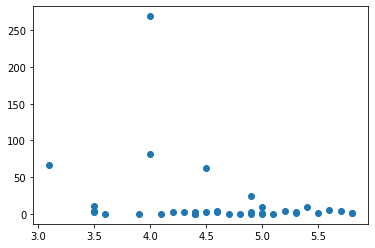

In [217]:
plt.scatter(x=county_total["Unemployment_rate_2018"],y=county_total["deaths_4_14_2020"])